<a href="https://colab.research.google.com/github/AlessioChen/Computer-Vision-Class/blob/main/CV_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch.optim as optim
import time
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

!pip install torchinfo
from torchinfo import summary


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Convolutional net

In [3]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 3, padding=2)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 3)
        self.conv3 = nn.Conv2d(16, 32, 3)
        self.fc1 = nn.Linear(32 * 13 * 13, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128,  64)
        self.fc4 = nn.Linear(64,  10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) # logits
        return x

In [4]:
model = Net()

print(summary(model))
model(torch.randn(1, 3, 32, 32))

Layer (type:depth-idx)                   Param #
Net                                      --
├─Conv2d: 1-1                            168
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            880
├─Conv2d: 1-4                            4,640
├─Linear: 1-5                            1,384,704
├─Linear: 1-6                            32,896
├─Linear: 1-7                            8,256
├─Linear: 1-8                            650
Total params: 1,432,194
Trainable params: 1,432,194
Non-trainable params: 0


tensor([[-0.0804, -0.0562,  0.1052, -0.0407, -0.1039,  0.0158, -0.0202,  0.0506,
         -0.0649, -0.0790]], grad_fn=<AddmmBackward0>)

In [5]:
def train(model, device, train_loader, criterion, optmizer):
  model.train()

  losses, accs = [], []
  correct = 0.

  for batch_idex, (data, target) in enumerate(train_loader):
     # get the inputs; data is a list of [inputs, labels]
    data, target = data.to(device), target.to(device)


    # zero the parameter gradients
    optmizer.zero_grad()

    # forward + backward + optimize
    outputs = model(data)
    loss = criterion(outputs, target)
    loss.backward()
    optmizer.step()

    # prediction
    pred = outputs.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct = torch.eq(pred, target.view_as(pred)).float()
    acc = torch.mean(correct)

    # update loss and accuracy
    losses.append(loss.detach().cpu().numpy())
    accs.append(acc.detach().cpu().numpy())

  return np.mean(losses), np.mean(accs)

In [6]:
def test(model, device, criterion, test_loader):
  model.eval() # Congifure the model in evaluation mode

  losses, accs = [], []
  correct = 0.

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      # Compute loss
      outputs = model(data)
      loss = criterion(outputs, target)

      # Prediction
      pred = outputs.argmax(dim=1, keepdim=True)
      correct = torch.eq(pred, target.view_as(pred)).float()
      acc = torch.mean(correct)

      # Update loss and accuracy
      losses.append(loss.detach().cpu().numpy())
      accs.append(acc.detach().cpu().numpy())

  return np.mean(losses), np.mean(accs)


In [7]:
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [8]:
def test_class(model, device, criterion, test_loader):
    model.eval()  # configura il modello in evaluation mode

    # prepare to count predictions for each class
    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    losses, accs = [], []
    correct = 0.

    with torch.no_grad():
        for data, target in test_loader:
            data, targets = data.to(device), target.to(device)

            ## Fit data
            output = model(data)

            ## Prediction
            preds = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            for target, pred in zip(targets, preds):
                if target == pred:
                    correct_pred[classes[target]] += 1
                total_pred[classes[target]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

In [9]:
def train_loop(train_loader, test_loader, model ,criterion, device, lr, momentum, max_epochs, do_test= True):

  model.to(device)

  optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

  train_losses, train_accs = [], []
  test_losses, test_accs = [], []

  _start = time.time()
  _epoch_time = time.time()

  for epoch in range(max_epochs):
    train_loss, train_acc = train(model, device, train_loader, criterion, optimizer)
    print(f"Epoch: {epoch}, Learning rate: {get_lr(optimizer):.6f}")
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    if do_test:
            loss_test, acc_test = test(model, device, criterion, test_loader)
            test_losses.append(loss_test)
            test_accs.append(acc_test)
            print(f"Test - Loss: {loss_test:.4f}, Accuracy: {acc_test:.2f}")

    _epoch_time = time.time()

  _end = time.time()
  print(f"Done! - Runtime: {(_end-_start):.2f} seconds")

  test_class(model, device, criterion, testloader)

  if do_test:
    return train_losses, train_accs, test_losses, test_accs
  else:
    return train_losses, train_accs


In [10]:
def simple_diagnostic(max_epochs, losses_train, accs_train):
    epochs_seq = np.arange(1, max_epochs + 1)
    # epoch_labels =

    # plot only training loss and accuracy
    fig, ax = plt.subplots()
    # fig.suptitle("Training performance")
    fig.suptitle("Training loss and accuracy againts epochs")

    color = "tab:blue"
    ax.plot(epochs_seq, losses_train, label="train loss", color=color)
    # ax.set_title("Training loss and accuracy againts epochs")
    ax.grid("both")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Loss", color=color)
    ax.tick_params(axis="y", labelcolor=color)
    ax.set_xticks(np.arange(1, max_epochs+1, step=2))
    ax.set_xticklabels(np.arange(1, max_epochs + 1, 2))

    color = "tab:red"
    ax_1 = ax.twinx()
    ax_1.plot(epochs_seq, accs_train, label="test accuracy", color="tab:red")
    ax_1.set_ylabel("Accuracy", color="tab:red")
    ax_1.tick_params(axis="y", labelcolor=color)

In [11]:
def multiple_diagnostic(loss_acc_dict, max_epochs=10, title_left="Training loss against epochs",
                       title_right="Test accuracy against epochs"):
    # loss_acc_dict = {"Solver1": [loss, acc]...}
    epochs_seq = np.arange(1, max_epochs + 1)

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), layout="constrained")
    # fig.suptitle("CNN training performance over CIFAR10")

    for solver_name, perf in loss_acc_dict.items():

        # plot loss function performance
        axs[0].plot(epochs_seq, perf[0], label=solver_name)
        axs[0].grid("both")
        axs[0].set_title(title_left)

        # plot accuracy performance
        axs[1].plot(epochs_seq, perf[1], label=solver_name)
        axs[1].grid("both")
        axs[1].set_title(title_right)

    axs[0].legend()
    axs[1].legend()

# Exercise 0
Find the correct mean and std of CIFAR10 dataset to normalize data correctly, i.e., to have data with mean 0 and std 1.


In [12]:
def compute_mean_and_std(trainloader):
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for X, _ in trainloader:
    # X -> (Batch examples, channels, width, height)
    X = torch.flatten(X, 2, 3) # (Batch examples, channels, width * height)

    # calculates the mean of pixel values along the flattened spatial dimension (`dim=2`) for each channel.
    # It then sums these channel-wise means across all examples in the batch (`sum(0)`).

    mean += X.mean(2).sum(0)
    std += X.std(2).sum(0)
    samples += X.shape[0]

  mean /= samples
  std /= samples

  return mean , std

In [14]:
# Witouth normalization
transform = transforms.Compose([transforms.ToTensor()])

batch_size = 64

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset =  datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,shuffle=False, num_workers=2)

mean, std = compute_mean_and_std(trainloader)

print(f"Mean {mean}")
print(f"Std {std}")



Files already downloaded and verified
Files already downloaded and verified
Mean tensor([0.4914, 0.4822, 0.4465])
Std tensor([0.2023, 0.1994, 0.2010])


In [15]:
# normalize data to have mean = 0 e std = 1
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset =  datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

mean, std = compute_mean_and_std(trainloader)

print(f"Mean {mean}")
print(f"Std {std}")

Files already downloaded and verified
Files already downloaded and verified
Mean tensor([ 9.5881e-07, -1.2238e-06, -1.1071e-06])
Std tensor([1.0000, 1.0000, 1.0000])


# Exercise 1
Try to use a scheduler for the learning rate (https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate).

- What are the differences?
- Does it improves the training convergence/test accuracy?

In [16]:
max_epochs = 20
es1_loss_acc = {}  # {"Solver1": [loss, acc]}
criterion = torch.nn.CrossEntropyLoss() # Inputes requires logits

## Basic training

In [17]:
model1 = Net()
model1.to(device)
lr = 0.001
momentum = 0.9

model1_dict = dict(model=model1, criterion=criterion, device=device, lr=lr, momentum=momentum,
                   max_epochs=max_epochs, do_test=True)

stats = train_loop(trainloader, testloader, **model1_dict)
es1_loss_acc["SGD"] = [stats[0], stats[3]]

Epoch: 0, Learning rate: 0.001000
Test - Loss: 2.3004, Accuracy: 0.12
Epoch: 1, Learning rate: 0.001000
Test - Loss: 2.2064, Accuracy: 0.20
Epoch: 2, Learning rate: 0.001000
Test - Loss: 1.9289, Accuracy: 0.32
Epoch: 3, Learning rate: 0.001000
Test - Loss: 1.7393, Accuracy: 0.37
Epoch: 4, Learning rate: 0.001000
Test - Loss: 1.5185, Accuracy: 0.45
Epoch: 5, Learning rate: 0.001000
Test - Loss: 1.4171, Accuracy: 0.48
Epoch: 6, Learning rate: 0.001000
Test - Loss: 1.3456, Accuracy: 0.52
Epoch: 7, Learning rate: 0.001000
Test - Loss: 1.2847, Accuracy: 0.55
Epoch: 8, Learning rate: 0.001000
Test - Loss: 1.2870, Accuracy: 0.54
Epoch: 9, Learning rate: 0.001000
Test - Loss: 1.1787, Accuracy: 0.58
Epoch: 10, Learning rate: 0.001000
Test - Loss: 1.1407, Accuracy: 0.60
Epoch: 11, Learning rate: 0.001000
Test - Loss: 1.0800, Accuracy: 0.62
Epoch: 12, Learning rate: 0.001000
Test - Loss: 1.0438, Accuracy: 0.63
Epoch: 13, Learning rate: 0.001000
Test - Loss: 1.0207, Accuracy: 0.64
Epoch: 14, Learn

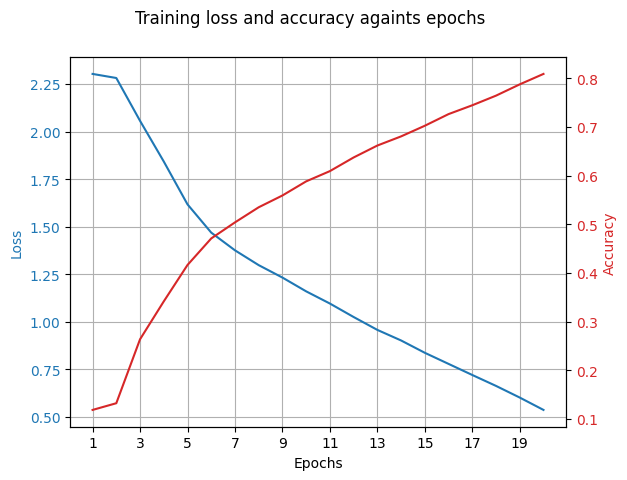

In [18]:
simple_diagnostic(max_epochs, stats[0], stats[1])

## Multi step scheduler

In [19]:
from torch.optim.lr_scheduler import MultiStepLR

model2 = Net()
model2.to(device)

lr = 0.008
momentum = 0.9
milestones = [10, 15]
gamma = 0.1

optimizer = optim.SGD(model2.parameters(), lr=lr, momentum=momentum)
scheduler = MultiStepLR(optimizer, milestones=milestones, gamma=gamma)

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()

for epoch in range(max_epochs):
  train_loss, train_acc = train(model2, device, trainloader, criterion, optimizer)

  print(f"Epoch: {epoch}, Learning rate: {get_lr(optimizer):.6f}")
  print(f"Training - Loss: {train_loss:.4f}, Accuracy: {train_acc:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")

  losses.append(train_loss)

  scheduler.step()

  ## test
  test_loss, test_acc = test(model2, device, criterion, testloader)
  accs.append(test_acc)

  print(f"Test - Loss: {test_loss:.4f}, Accuracy: {test_acc:.2f}")

  _epoch_time = time.time()

print(f"Runtime: {(time.time() - _start):.2f} seconds")

test_class(model2, device, criterion, testloader)

es1_loss_acc["SGD-Step"] = [losses, accs]

Epoch: 0, Learning rate: 0.008000
Training - Loss: 1.9041, Accuracy: 0.30, Runtime: 15.16
Test - Loss: 1.5365, Accuracy: 0.45
Epoch: 1, Learning rate: 0.008000
Training - Loss: 1.3907, Accuracy: 0.50, Runtime: 15.61
Test - Loss: 1.2664, Accuracy: 0.56
Epoch: 2, Learning rate: 0.008000
Training - Loss: 1.1626, Accuracy: 0.59, Runtime: 14.73
Test - Loss: 1.0992, Accuracy: 0.61
Epoch: 3, Learning rate: 0.008000
Training - Loss: 0.9979, Accuracy: 0.65, Runtime: 14.81
Test - Loss: 1.0089, Accuracy: 0.65
Epoch: 4, Learning rate: 0.008000
Training - Loss: 0.8500, Accuracy: 0.70, Runtime: 15.41
Test - Loss: 1.0149, Accuracy: 0.64
Epoch: 5, Learning rate: 0.008000
Training - Loss: 0.7013, Accuracy: 0.75, Runtime: 14.77
Test - Loss: 1.0169, Accuracy: 0.67
Epoch: 6, Learning rate: 0.008000
Training - Loss: 0.5579, Accuracy: 0.81, Runtime: 14.75
Test - Loss: 1.1088, Accuracy: 0.66
Epoch: 7, Learning rate: 0.008000
Training - Loss: 0.4298, Accuracy: 0.85, Runtime: 16.91
Test - Loss: 1.2265, Accurac

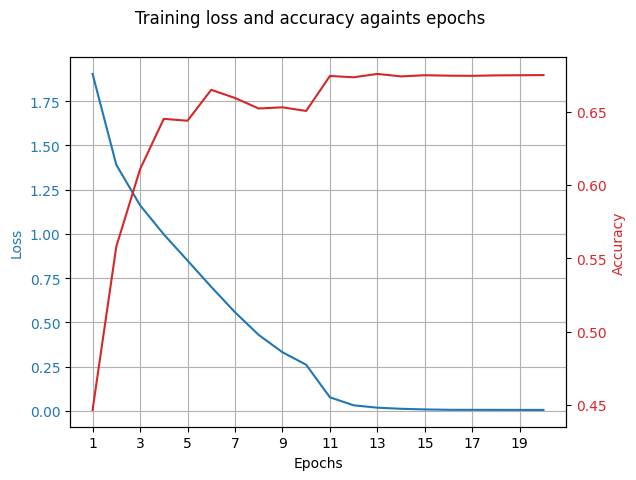

In [20]:
simple_diagnostic(max_epochs, losses, accs)

## Exponential Scheduler

In [21]:
from torch.optim.lr_scheduler import ExponentialLR

model3 = Net()
model3.to(device)

lr = 0.01
momentum = 0.9

optimizer = optim.SGD(model3.parameters(),lr =lr , momentum=momentum)
scheduler = ExponentialLR(optimizer, 0.95)  # a_k *= 0.95**k

losses, accs = [], []
_start = time.time()
_epoch_time = time.time()
for epoch in range(max_epochs):
    ## train
    loss_train, acc_train = train(model3, device, trainloader, criterion, optimizer)
    print(f"Epoch: {epoch}, Learning rate: {get_lr(optimizer):.6f}")
    print(f"Training - Loss: {loss_train:.4f}, Accuracy: {acc_train:.2f}, Runtime: {(time.time() - _epoch_time):.2f}")
    losses.append(loss_train)
    scheduler.step()
    ## test
    loss_test, acc_test = test(model3, device, criterion, testloader)
    accs.append(acc_test)
    print(f"Test - Loss: {loss_test:.4f}, Accuracy: {acc_test:.2f}")
    _epoch_time = time.time()
print(f"Runtime: {(time.time() - _start):.2f} seconds")

es1_loss_acc["SGD-Exp"] = [losses, accs]

test_class(model3, device, criterion, testloader)

Epoch: 0, Learning rate: 0.010000
Training - Loss: 1.8776, Accuracy: 0.31, Runtime: 14.31
Test - Loss: 1.4975, Accuracy: 0.46
Epoch: 1, Learning rate: 0.009500
Training - Loss: 1.3212, Accuracy: 0.53, Runtime: 14.42
Test - Loss: 1.2766, Accuracy: 0.54
Epoch: 2, Learning rate: 0.009025
Training - Loss: 1.0981, Accuracy: 0.61, Runtime: 15.04
Test - Loss: 1.0632, Accuracy: 0.62
Epoch: 3, Learning rate: 0.008574
Training - Loss: 0.9323, Accuracy: 0.67, Runtime: 15.76
Test - Loss: 0.9999, Accuracy: 0.65
Epoch: 4, Learning rate: 0.008145
Training - Loss: 0.7728, Accuracy: 0.73, Runtime: 14.02
Test - Loss: 1.0088, Accuracy: 0.66
Epoch: 5, Learning rate: 0.007738
Training - Loss: 0.6173, Accuracy: 0.78, Runtime: 14.85
Test - Loss: 1.0496, Accuracy: 0.65
Epoch: 6, Learning rate: 0.007351
Training - Loss: 0.4553, Accuracy: 0.84, Runtime: 14.31
Test - Loss: 1.1903, Accuracy: 0.65
Epoch: 7, Learning rate: 0.006983
Training - Loss: 0.3252, Accuracy: 0.89, Runtime: 14.38
Test - Loss: 1.3380, Accurac

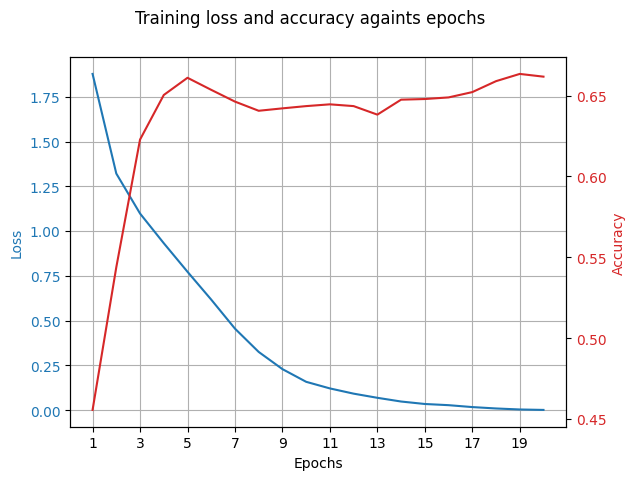

In [23]:
simple_diagnostic(max_epochs, losses, accs)

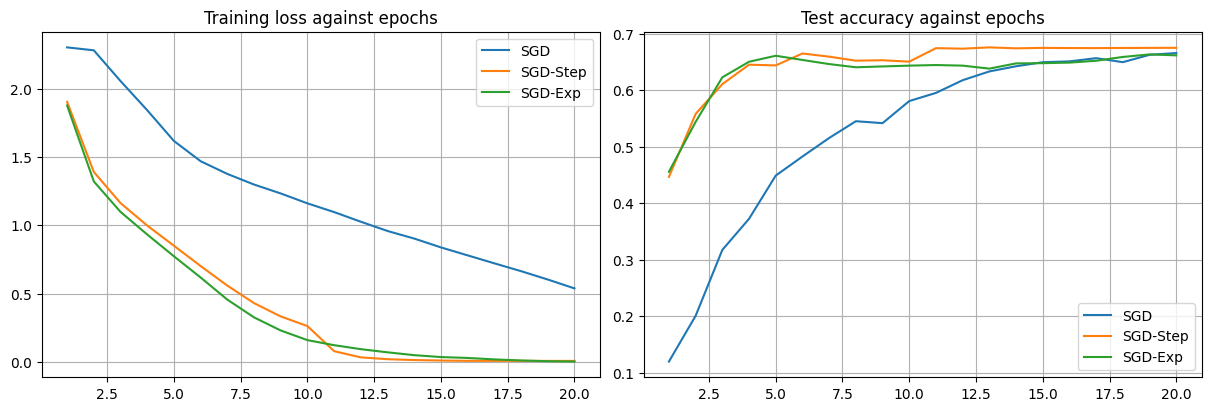

In [22]:
multiple_diagnostic(es1_loss_acc, max_epochs)

# Exercise 2

Use some data augmentation to reduce overfitting.

All the transformations supported by PyTorch can be found at https://pytorch.org/vision/0.9/transforms.html#compositions-of-transforms

- Which transformations are the most impactfull on the accuracies?

Try to plot the effect of the transformations!

# Exercise 3
A) Try to change the network architecture (e.g. use all linear layers) or network hyperparameters (e.g. dimensions of the CNN kernel, stride, padding).

B) Try also to compare performance of your model with performance of pre-defined network architecture.
There are a lot of pre-defined network architectures (e.g. ResNet, VGG, AlexNet, ...).

Some example can be found in https://pytorch.org/vision/0.9/models.html.

Specific CIFAR10 architectures are also in this public repository https://github.com/kuangliu/pytorch-cifar.